# RLC
Notebook to summarize experiments on the RLC circuit dataset. Run the code below, as soon as you have run all the other notebooks.


In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import sys
from collections import defaultdict
from pathlib import Path

from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', datefmt='%I:%M:%S')

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import scipy
import torch
import os
from tqdm import tqdm

sys.path.append('../..')
from tsfewshot.config import Config
from tsfewshot import plot, analyses

np.random.seed(0)
torch.random.manual_seed(0)

DEVICE = 'cuda:0'
SUPPORT_SIZES = [10, 20, 30, 50, 70, 100]
QUERY_SIZE = 2000

CODE_DIR = Path('../..')
DATA_DIR = 'data/rlc_dataset-resistor_range1_14-capacitor_range100_800-inductor_range20_140'

In [2]:
# jfr run
jfr_path = Path('data/jfr_baseline_results.p').resolve()
with open(jfr_path, 'rb') as f:
    results = pickle.load(f)

def eval_results_to_df(eval_results: dict, metric='mse'):
    results = {}
    model_type_index = None
    for ds_name, ds_res in eval_results.items():
        results[ds_name] = {(support_size, mt): ds_ss_res[metric][mt] for support_size, ds_ss_res in ds_res.items() for mt in ds_ss_res[metric]} 
    
    # add seed level to multiindex
    # fill with seed 0
    multi_ind = pd.MultiIndex.from_tuples(results[ds_name].keys(), names=['support', 'type'])
    results_df = pd.DataFrame(results, index=multi_ind) # no transpose() here otherwise indexing will result in NaNs
    indices = [t + (0,) for t in list(results[ds_name].keys())]
    multi_ind = pd.MultiIndex.from_tuples(indices, names=['support', 'type', 'seed'])
    return results_df.reindex(multi_ind).transpose()

df_jfr = eval_results_to_df(results, metric='mse')
df_jfr = df_jfr[SUPPORT_SIZES]
df_jfr = df_jfr.rename(columns={'no_finetune': 'no-finetune jfr', 'jfr_model': 'jfr'})
display_df = df_jfr.copy()
median = display_df.median(axis=0)
mean = display_df.mean(axis=0)
display_df.loc[' median'] = median
display_df.loc[' mean'] = mean
display(display_df.sort_index().style.background_gradient('Greens_r', axis=1).highlight_null('white'))

In [3]:
# supervised run
RUN_SUPERVISED = Path('runs/supervised/rlc-ode-3traintraj-supervised-ode50-lr1e-4-bs16-seqlen256-seed0').resolve()
# load metrics when re-executing the notebook, so we don't have to recalculate
metrics = pickle.load((RUN_SUPERVISED / 'metrics.p').open('rb'))
best_ft_options = pickle.load((RUN_SUPERVISED / 'best_ft_options.p').open('rb'))
best_ft_epochs = pickle.load((RUN_SUPERVISED / 'best_ft_epochs.p').open('rb'))
df_supervised = pd.DataFrame({k: v['mse'] for k, v in metrics[0.0].items()}, dtype=float)
df_supervised.columns.names = ['support', 'type', 'seed']
df_supervised = df_supervised.rename(columns={'no-finetune': 'no-finetune supervised', 'normal noise 0.0 ': 'normal supervised', 'pca noise 0.0 ': 'pca supervised'})

# results table
display_df = df_supervised.copy()
median = display_df.median(axis=0)
mean = display_df.mean(axis=0)
display_df.loc[' rank'] = display_df.groupby('support', axis=1).rank(axis=1).median(axis=0)
display_df.loc[' median'] = median
display_df.loc[' mean'] = mean
display(display_df.sort_index().style.background_gradient('Greens_r', axis=1).highlight_null('white'))

site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))
site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [4]:
# maml run
RUN_MAML = Path('runs/fomaml/rlc-ode-3trtraj-fomaml-50support16batch5steplr0.001innerlr0.001-finetune5-seed0').resolve()
# load metrics when re-executing the notebook, so we don't have to recalculate
metrics = pickle.load((RUN_MAML / 'metrics.p').open('rb'))
best_ft_options = pickle.load((RUN_MAML / 'best_ft_options.p').open('rb'))
best_ft_epochs = pickle.load((RUN_MAML / 'best_ft_epochsp').open('rb'))
df_maml = pd.DataFrame({k: v['mse'] for k, v in metrics[0.0].items()}, dtype=float)
df_maml.columns.names = ['support', 'type', 'seed']
df_maml = df_maml.rename(columns={'no-finetune': 'no-finetune fomaml', 'normal noise 0.0 ': 'normal fomaml', 'pca noise 0.0 ': 'pca fomaml'})
# results table
display_df = df_maml.copy()
median = display_df.median(axis=0)
mean = display_df.mean(axis=0)
display_df.loc[' rank'] = display_df.groupby('support', axis=1).rank(axis=1).median(axis=0)
display_df.loc[' median'] = median
display_df.loc[' mean'] = mean
display(display_df.sort_index().style.background_gradient('Greens_r', axis=1).highlight_null('white'))

site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))
site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [5]:
# reptile run
RUN_REPTILE = Path('runs/reptile/rlc-ode-3trtraj-reptile-50support10batch5steplr0.001innerlr0.001-finetune5-seed0').resolve()
# load metrics when re-executing the notebook, so we don't have to recalculate
metrics = pickle.load((RUN_REPTILE / 'metrics.p').open('rb'))
best_ft_options = pickle.load((RUN_REPTILE / 'best_ft_options.p').open('rb'))
best_ft_epochs = pickle.load((RUN_REPTILE / 'best_ft_epochs.p').open('rb'))
df_reptile = pd.DataFrame({k: v['mse'] for k, v in metrics[0.0].items()}, dtype=float)
df_reptile.columns.names = ['support', 'type', 'seed']
df_reptile = df_reptile.rename(columns={'no-finetune': 'no-finetune reptile', 'normal noise 0.0 ': 'normal reptile', 'pca noise 0.0 ': 'pca reptile'})
# results table
display_df = df_reptile.copy()
median = display_df.median(axis=0)
mean = display_df.mean(axis=0)
display_df.loc[' rank'] = display_df.groupby('support', axis=1).rank(axis=1).median(axis=0)
display_df.loc[' median'] = median
display_df.loc[' mean'] = mean
display(display_df.sort_index().style.background_gradient('Greens_r', axis=1).highlight_null('white'))

site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [6]:
df_res = pd.concat([df_supervised, df_maml, df_reptile, df_jfr], axis=1)
# results table
display_df = df_res.copy()
median = display_df.median(axis=0)
mean = display_df.mean(axis=0)
display_df.loc[' rank'] = display_df.groupby('support', axis=1).rank(axis=1).median(axis=0)
display_df.loc[' median'] = median
display_df.loc[' mean'] = mean
display(display_df.sort_index().style.background_gradient('Greens_r', axis=1).highlight_null('white'))

site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))
site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [19]:
display_df.iloc[:,display_df.columns.get_level_values(1)=='normal supervised'].round(3)

support                                                                                                                               10   \
type                                                                                                                    normal supervised   
seed                                               (rlc-ode-ds2-3traintraj-supervised-ode50-lr1e-4-bs16-seqlen256-seed0_220224_083433, 0)   
test/R:1.0249437636881251_L:0.00010726452771948...                                              0.610                                       
test/R:1.1586005688888497_L:8.693189183448564e-...                                              0.480                                       
test/R:1.1970406984962436_L:4.581432462508986e-...                                              0.127                                       
test/R:1.332428795631129_L:3.301060869307106e-0...                                              0.039                                       
test/R:1.3402772427181766_L:4.746310122094462e-...                                              0.077                                       
...                                                                                               ...                                       
test/R:9.972763007882042_L:0.000107607164399691...                                              0.302                                       
test/R:9.983958501079368_L:0.000125844034978489...                                              0.321                                       
 rank                                                                                           9.000                                       
 median                                                                                         0.213                                       
 mean                                                                                           0.235                                       

support                                                                                                                               20   \
type                                                                                                                    normal supervised   
seed                                               (rlc-ode-ds2-3traintraj-supervised-ode50-lr1e-4-bs16-seqlen256-seed0_220224_083433, 0)   
test/R:1.0249437636881251_L:0.00010726452771948...                                              0.585                                       
test/R:1.1586005688888497_L:8.693189183448564e-...                                              0.421                                       
test/R:1.1970406984962436_L:4.581432462508986e-...                                              0.111                                       
test/R:1.332428795631129_L:3.301060869307106e-0...                                              0.065                                       
test/R:1.3402772427181766_L:4.746310122094462e-...                                              0.271                                       
...                                                                                               ...                                       
test/R:9.972763007882042_L:0.000107607164399691...                                              0.203                                       
test/R:9.983958501079368_L:0.000125844034978489...                                              0.243                                       
 rank                                                                                           8.000                                       
 median                                                                                         0.173                                       
 mean                                                                                           0.202                                       

support                                           

In [8]:
# Supervised+SGD      &0.213 &0.173 &0.100 &0.033 &0.023 &0.019 \\
# Supervised+SubGD    &0.114 &0.043 &0.025 &0.016 &0.015 &0.014 \\
# foMAML              &0.074 &0.045 &0.029 &0.020 &0.020 &0.019 \\
# foMAML+SubSGD       &0.067 &0.042 &0.025 &0.018 &0.015 &0.014 \\
# Reptile             &0.058 &0.061 &0.053 &0.037 &0.029 &0.026 \\
# Reptile+SubGD       &0.054 &0.033 &0.022 &0.017 &0.015 &0.015 \\

In [9]:
from matplotlib import rc
rc('text', usetex=True)

In [11]:
df_res.columns.get_level_values('type').unique().sort_values()

Index(['jfr', 'no-finetune fomaml', 'no-finetune jfr', 'no-finetune reptile',
       'no-finetune supervised', 'normal fomaml', 'normal reptile',
       'normal supervised', 'pca fomaml', 'pca reptile', 'pca supervised'],
      dtype='object', name='type')

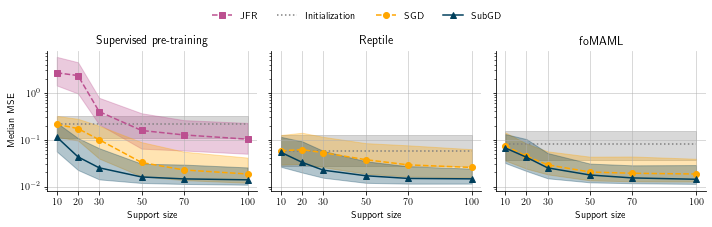

In [12]:
figsize = (10,3)
f = plot.plot_support_vs_mse_rlc(df_res,
                             SUPPORT_SIZES,
                             figsize=figsize,
                             aggregation='median',
                             title='', 
                             exclude_types=[],
                             metric_name='MSE', 
                             style = {
                                'jfr': {'ls': '--', 'col': '#bc5090', 'marker': 's', 'label': 'JFR'}, 
                                'no-finetune jfr': {'ls': ':', 'col': '#bc5090', 'marker': '', 'label': 'JFR Initialization'}, 
                                'pca fomaml': {'ls': '-', 'col': '#003f5c', 'marker': '^', 'label': 'SubGD'},
                                'pca reptile': {'ls': '-', 'col': '#003f5c', 'marker': '^', 'label': ''},
                                'pca supervised': {'ls': '-', 'col': '#003f5c', 'marker': '^', 'label': ''},
                                'normal fomaml': {'ls': '--', 'col': '#ffa600', 'marker': 'o', 'label': 'SGD'},
                                'normal reptile': {'ls': '--', 'col': '#ffa600', 'marker': 'o', 'label': ''},
                                'normal supervised': {'ls': '--', 'col': '#ffa600', 'marker': 'o', 'label': ''},
                                'no-finetune fomaml': {'ls': ':', 'col': 'grey', 'marker': '', 'label': 'Initialization'},
                                'no-finetune reptile': {'ls': ':', 'col': 'grey', 'marker': '', 'label': ''},
                                'no-finetune supervised': {'ls': ':', 'col': 'grey', 'marker': '', 'label': ''},
                                }, 
                           alpha=0.3)
# plt.ylim(0,0.28)
# plt.yscale('log')

In [13]:
f.savefig("rlc-support-vs-mse-median_all_log.pdf", bbox_inches="tight")

(0.0, 0.28)

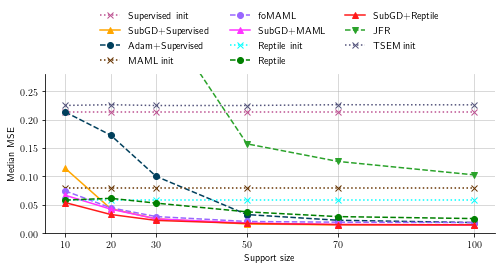

In [14]:
figsize = (7,4)
f = plot.plot_support_vs_mse(df_res,
                             SUPPORT_SIZES,
                             ranks=False,
                             figsize=figsize,
                             aggregation='median',
                             title='', 
                             exclude_types=[],
                             metric_name='MSE', 
                             style = {
                                'normal supervised': {'ls': '--', 'col': '#003f5c', 'marker': 'o', 'label': 'Adam+Supervised'},
                                'pca supervised': {'ls': '-', 'col': '#ffa600', 'marker': '^', 'label': 'SubGD+Supervised'},
                                'no-finetune supervised': {'ls': ':', 'col': '#bc5090', 'marker': 'x', 'label': 'Supervised init'},
                                'jfr': {'ls': '--', 'col': '#2aa22a', 'marker': 'v', 'label': 'JFR'}, 
                                'no-finetune jfr': {'ls': ':', 'col': '#52527a', 'marker': 'x', 'label': 'TSEM init'}, 
                                'pca fomaml': {'ls': '-', 'col': '#ff33ff', 'marker': '^', 'label': 'SubGD+MAML'},
                                'pca reptile': {'ls': '-', 'col': '#ff1a1a', 'marker': '^', 'label': 'SubGD+Reptile'},
                                'normal fomaml': {'ls': '--', 'col': '#9966ff', 'marker': 'o', 'label': 'foMAML'},
                                'normal reptile': {'ls': '--', 'col': '#008000', 'marker': 'o', 'label': 'Reptile'},
                                'no-finetune fomaml': {'ls': ':', 'col': '#663300', 'marker': 'x', 'label': 'MAML init'},
                                'no-finetune reptile': {'ls': ':', 'col': '#00ffff', 'marker': 'x', 'label': 'Reptile init'},
                                }, 
                           alpha=0.2)
plt.ylim(0,0.28)

In [15]:
f.savefig("rlc-support-vs-mse-median_all_lim_no-errorbars.pdf", bbox_inches="tight")

In [16]:
# significance test
from scipy.stats import wilcoxon
p = {}
noise = 0.0
sig_df = df_res.groupby(['support', 'type'], axis=1).agg(lambda s: s.mean(skipna=False))
best_typs = {support: sig_df.loc[:, support].median().idxmin(axis=1) for support in SUPPORT_SIZES}
for support, typ in sig_df.columns:
    if typ == f'{best_typs[support]} noise 0.0 ':
        p[(support, typ)] = np.nan
        continue
    if ((sig_df.loc[:, (support, typ)] - sig_df.loc[:, (support, best_typs[support])]) == 0).all():
        p[(support, typ)] = np.nan
        continue
    p[(support, typ)] = wilcoxon(sig_df.loc[:, (support, typ)], sig_df.loc[:, (support, best_typs[support])])[1]
sig_df = pd.DataFrame(p, index=['p-value']).T
sig_df.index.names = ['support', 'type']
display(sig_df.reset_index().pivot(index='type', columns='support', values='p-value').style.format('{:.3e}'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed:    9.7s finished
100%|██████████| 512/512 [00:31<00:00, 16.13it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed:   10.0s finished
100%|██████████| 512/512 [00:14<00:00, 35.46it/s] 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed:   10.0s finished
100%|██████████| 512/512 [00:14<00:00, 35.78it/s] 


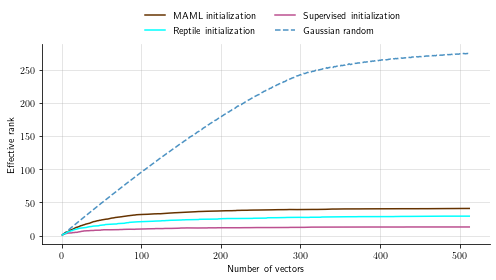

In [ ]:
plt.figure(figsize=(7,4))
finetune_dirs = list((RUN_SUPERVISED / f'finetune_adam_flr5e-06_n_fts512').glob('rlc*/')) 
cfg = Config(RUN_SUPERVISED / 'config.yml')
f, ax = plot.plot_deltas_rank(cfg, finetune_dirs,
                              tols=[0],
                              ax=plt.gca(),
                              random_baseline=True,
                              n_repeats=1,
                              task_steps=1,
                              within_task_steps=None,
                              epoch_steps=None,
                              use_erank=True,
                              colors=['#bc5090'],
                              init_epoch=-1,
                              plot_val_metric=False, 
                              plot_details=False, 
                              label_suffix='Supervised initialization')

finetune_dirs = list((RUN_MAML / f'finetune_adam_flr5e-06_n_fts512').glob('rlc*/')) 
cfg = Config(RUN_MAML / 'config.yml')
f, ax = plot.plot_deltas_rank(cfg, finetune_dirs,
                              tols=[0],
                              ax=plt.gca(),
                              random_baseline=False,
                              n_repeats=1,
                              task_steps=1,
                              within_task_steps=None,
                              epoch_steps=None,
                              use_erank=True,
                              colors=['#663300'],
                              init_epoch=-1,
                              plot_val_metric=False, 
                              plot_details=False, 
                              label_suffix='MAML initialization')

finetune_dirs = list((RUN_REPTILE / f'finetune_adam_flr5e-06_n_fts512').glob('rlc*/')) 
cfg = Config(RUN_REPTILE / 'config.yml')
f, ax = plot.plot_deltas_rank(cfg, finetune_dirs,
                              tols=[0],
                              ax=plt.gca(),
                              random_baseline=False,
                              n_repeats=1,
                              task_steps=1,
                              within_task_steps=None,
                              epoch_steps=None,
                              use_erank=True,
                              colors=['#00ffff'],
                              init_epoch=-1,
                              plot_val_metric=False, 
                              plot_details=False, 
                              label_suffix='Reptile initialization')

# plt.xscale('log')
# plt.yscale('log')
plt.tight_layout()
plt.savefig('rlc-pretrain-erank.pdf', bbox_inches="tight")

Num outlier: [support 10 - type normal adam noise 0.0 ]: 0
Num outlier: [support 10 - type pca-adam noise 0.0 ]: 22
Num outlier: [support 20 - type normal adam noise 0.0 ]: 11
Num outlier: [support 20 - type pca-adam noise 0.0 ]: 6
Num outlier: [support 30 - type normal adam noise 0.0 ]: 1
Num outlier: [support 30 - type pca-adam noise 0.0 ]: 4
Num outlier: [support 50 - type normal adam noise 0.0 ]: 1
Num outlier: [support 50 - type pca-adam noise 0.0 ]: 7
Num outlier: [support 70 - type normal adam noise 0.0 ]: 1
Num outlier: [support 70 - type pca-adam noise 0.0 ]: 1
Num outlier: [support 100 - type normal adam noise 0.0 ]: 2
Num outlier: [support 100 - type pca-adam noise 0.0 ]: 1


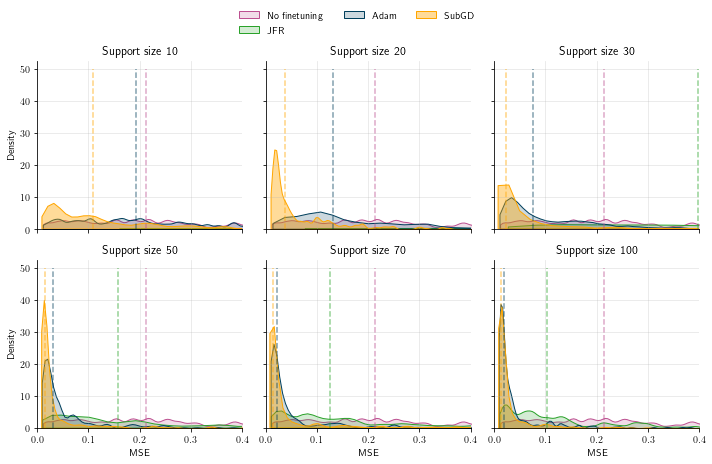

In [ ]:
# KDE plot all support sizes
outlier_threshold_mse = 6
outliers = {}
# fig = plt.figure()
f, axs = plt.subplots(2, 3, figsize=(10, 6), sharey=True, sharex=True)
supports = np.array([[10,20,30],[50,70,100]])
style = {
    'normal adam noise 0.0 ': {'ls': '--', 'col': '#003f5c', 'marker': 'o', 'label': 'Adam'},
    'pca-adam noise 0.0 ': {'ls': '-', 'col': '#ffa600', 'marker': '^', 'label': 'SubGD'},
    'no-finetune': {'ls': '--', 'col': '#bc5090', 'marker': 'x', 'label': 'No finetuning'},
    'jfr_model': {'ls': '--', 'col': '#2aa22a', 'marker': 'v', 'label': 'JFR'}}
type_specs = ['no-finetune', 'jfr_model', 'normal adam noise 0.0 ',
       'pca-adam noise 0.0 ']
# type_specs = ['pca-adam noise 0.0 ']
import seaborn as sns
for axrow, supportrow in zip(axs, supports):
    for ax, support in zip(axrow, supportrow):#, 50, 70, 100]):
        ax.set_title(f'Support size {support}')
        ax.grid(alpha=0.3)
        support_data = df_res.loc[:,support]
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        for i, typ in enumerate(type_specs):
            type_name = typ #f'{typ} noise 0.0 ' if typ != 'no-finetune' else typ
            # remove outlier
            if typ in ['normal adam noise 0.0 ', 'pca-adam noise 0.0 ']:
                data = [i for i in sorted(support_data.loc[:, type_name].values[:,0]) if i < outlier_threshold_mse]
                outlier = [i for i in sorted(support_data.loc[:, type_name].values[:,0]) if i > outlier_threshold_mse]
                print(f'Num outlier: [support {support} - type {type_name}]: {len(outlier)}')
            else:
                data = support_data.loc[:, type_name].values[:,0]
            # print(outlier)
            outliers[support] = outlier
            sns.kdeplot(data, 
                        color=style[type_name]['col'],
                        bw_adjust=0.15,
                        fill=style[type_name]['col'],
                        label=style[type_name]['label'] if ax == axs[0,0] else None,
                        ax=ax,
                        alpha=0.2 if type_name != 'pca-adam noise 0.0 ' else 0.4, 
                        cut=0)
            median = support_data.loc[:, type_name].median(axis=0).item()
            ax.vlines(median, 0, 50, colors=[style[type_name]['col']], linestyles='--', alpha=0.5)
        ax.set_xlim(0,0.4)
# # add a big axis, hide frame
# f.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axis
# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# plt.xlabel("MSE")
# plt.ylabel("Density")
axs[1,0].set_xlabel('MSE')
axs[1,1].set_xlabel('MSE')
axs[1,2].set_xlabel('MSE')
axs[0,0].set_ylabel('Density')
axs[0,0].set_ylabel('Density')
plt.figlegend(frameon=False, loc='lower center', bbox_to_anchor=(0.5, 0.98), ncol=3)
plt.tight_layout()
plt.savefig(f'rlc-kde-threshold_mse{outlier_threshold_mse}.pdf', bbox_inches='tight')

In [ ]:
# # Histogram plot
# f, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True, sharex=True)
# style = {
#     'normal adam noise 0.0 ': {'ls': '--', 'col': '#003f5c', 'marker': 'o', 'label': 'Adam'},
#     'pca-adam noise 0.0 ': {'ls': '-', 'col': '#ffa600', 'marker': '^', 'label': 'SubGD'},
#     'no-finetune': {'ls': '--', 'col': '#bc5090', 'marker': 'x', 'label': 'No finetuning'},
#     'jfr_model': {'ls': '--', 'col': '#2aa22a', 'marker': 'v', 'label': 'JFR'}}
# type_specs = ['no-finetune', 'jfr_model', 'normal adam noise 0.0 ',
#        'pca-adam noise 0.0 ']
# type_specs = ['pca-adam noise 0.0 ']
# import seaborn as sns
# for ax, support in zip(axs, [30, 50, 100]):
#     ax.set_title(f'Support size {support}')
#     ax.grid(alpha=0.3)
#     support_data = df_res.loc[:,support]
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     for i, typ in enumerate(type_specs):
#         type_name = typ #f'{typ} noise 0.0 ' if typ != 'no-finetune' else typ
#         sns.histplot(support_data.loc[:, type_name].values[:,0], 
#                     color=style[type_name]['col'],
#                     fill=style[type_name]['col'],
#                     # label=style[type_name]['label'] if ax == axs[0] else None,
#                     ax=ax,
#                     alpha=0.2 if type_name != 'pca-adam noise 0.0 ' else 0.4)
#     ax.set_xlim(-10,100)
    
# axs[1].set_xlabel('MSE')
# axs[0].set_ylabel('Density')
# plt.figlegend(frameon=False, loc='lower center', bbox_to_anchor=(0.5, 0.98), ncol=3)
# plt.tight_layout()
# plt.savefig('./plots/hydrology-kde.pdf', bbox_inches='tight')

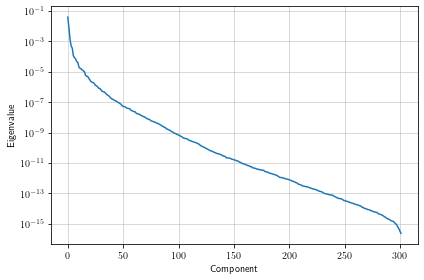

In [ ]:
# Plot eigenvalue distribution
pca = pickle.load((RUN_SUPERVISED / 'pca/pca-torchcenterFalseNonecomponentspathNoneimprovedFalseusestepsNonelayerwiseFalse.p').open('rb'))
eigenvalues = pca['s']**2 / (pca['u'].shape[0] - 1)
f, ax = plt.subplots(1,1, figsize=(6,4))
plt.plot(eigenvalues)
plt.ylabel('Eigenvalue')
plt.xlabel('Component')
plt.grid(alpha=0.6)
plt.yscale('log')
plt.tick_params(axis='y', which='minor')
plt.tight_layout()